# Anomaly detection in time-series data using MXNet and NAB dataset

In [24]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import mxnet as mx
from mxnet import nd, autograd, gluon

from sklearn import preprocessing
from sklearn.metrics import f1_score

In [2]:
nab_path = './NAB'
nab_data_path = nab_path + '/data/'

labels_filename = '/labels/combined_labels.json'
training_file_name = 'realAWSCloudwatch/rds_cpu_utilization_e47b3b.csv'
test_file_name = 'realAWSCloudwatch/rds_cpu_utilization_cc0c53.csv'

## Load labels from NAB dataset

In [3]:
labels_file = open(nab_path + labels_filename, 'r')
labels = json.loads(labels_file.read())
labels_file.close()

print('Training file anomalies labels: ', labels[training_file_name])
print('Test file anomalies labels: ', labels[test_file_name])

Training file anomalies labels:  ['2014-04-13 06:52:00', '2014-04-18 23:27:00']
Test file anomalies labels:  ['2014-02-25 07:15:00', '2014-02-27 00:50:00']


## Load Training Data

We take real AWS Cloudwatch data from some RDS instance for the study. Adding information on labled anomalies we have right from the start for visibility. 

In [4]:
def load_data_frame_with_labels(file_name):
    data_frame = pd.read_csv(nab_data_path + file_name)
    data_frame['anomaly_label'] = data_frame['timestamp'].isin(
        labels[file_name]).astype(int)
    return data_frame


training_data_frame = load_data_frame_with_labels(training_file_name)
training_data_frame.shape

(4032, 3)

In [5]:
training_data_frame.head()

,timestamp,value,anomaly_label
0,2014-04-10 00:02:00,14.012,0
1,2014-04-10 00:07:00,13.334,0
2,2014-04-10 00:12:00,15.000,0
3,2014-04-10 00:17:00,13.998,0
4,2014-04-10 00:22:00,14.332,0


## Load Test Data

There is another file with real AWS Cloudwatch data from some RDS instance. It has also labeled anomalies. We will use it as a Test dataset at the end to calculate F1 score.

In [6]:
test_data_frame = load_data_frame_with_labels(test_file_name)
test_data_frame.shape

(4032, 3)

In [7]:
test_data_frame.head()

,timestamp,value,anomaly_label
0,2014-02-14 14:30:00,6.456,0
1,2014-02-14 14:35:00,5.816,0
2,2014-02-14 14:40:00,6.268,0
3,2014-02-14 14:45:00,5.816,0
4,2014-02-14 14:50:00,5.862,0


## Plotting training and test data

In [8]:
def convert_timestamps(data_frame):
    data_frame['timestamp'] = pd.to_datetime(data_frame['timestamp'])
    data_frame['time_epoch'] = data_frame['timestamp'].astype(np.int64)


convert_timestamps(training_data_frame)
convert_timestamps(test_data_frame)

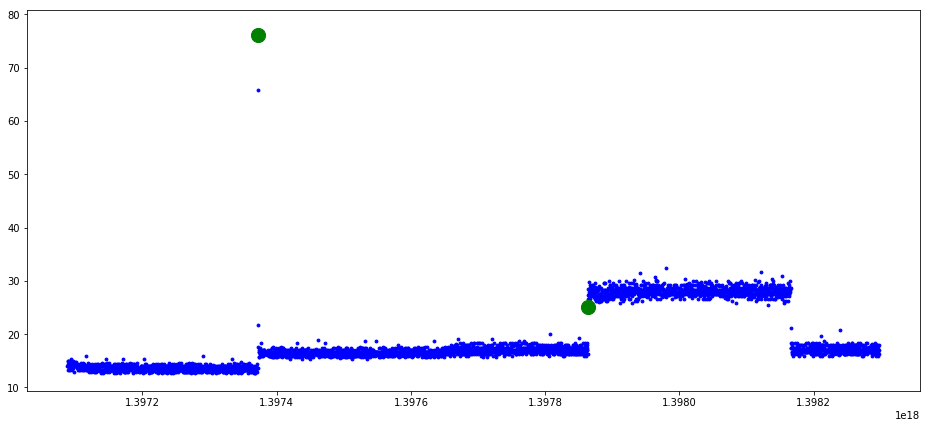

In [9]:
def prepare_plot(data_frame):
    fig, ax = plt.subplots()
    ax.scatter(data_frame['time_epoch'],
               data_frame['value'], s=8, color='blue')

    labled_anomalies = data_frame.loc[data_frame['anomaly_label'] == 1, [
        'time_epoch', 'value']]
    ax.scatter(labled_anomalies['time_epoch'],
               labled_anomalies['value'], s=200, color='green')

    return ax


figsize(16, 7)
prepare_plot(training_data_frame)
plt.show()

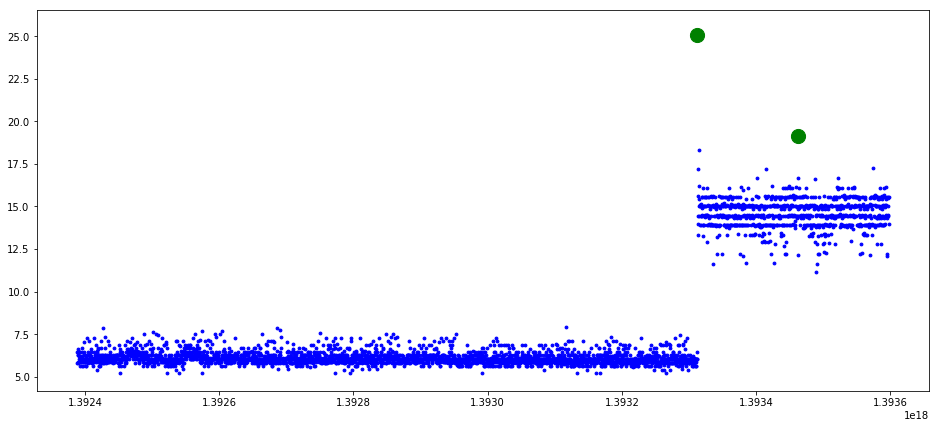

In [10]:
figsize(16, 7)
prepare_plot(test_data_frame)
plt.show()

## Replacing anomaly values in the training set

We have tested 2 approaches: training on unprepared data and training on dataset with masked anomalies. For our case working with the dataset that has masked anomalies gives us better results with furhter anomaly detection.

In [11]:
training_data_frame['value_no_anomaly'] = training_data_frame[training_data_frame['anomaly_label'] == 0]['value']
training_data_frame['value_no_anomaly'] = training_data_frame['value_no_anomaly'].fillna(method='ffill')

Comment the following line to worked with original data that includes anomalies

In [12]:
training_data_frame['value'] = training_data_frame['value_no_anomaly']

## Scale the train data

In [13]:
features = ['value']
feature_count = len(features)

data_scaler = preprocessing.StandardScaler()
data_scaler.fit(training_data_frame[features].values.astype(np.float32))

training_data = data_scaler.transform(
    training_data_frame[features].values.astype(np.float32)
)

## Prepare training and validation data

In [14]:
rows = len(training_data)

split_factor = 0.8

training = training_data[0:int(rows * split_factor)]
validation = training_data[int(rows * split_factor):]

## Choosing a model

We focus on LSTM NN for this case.

In [15]:
model = mx.gluon.nn.Sequential()
with model.name_scope():
    model.add(mx.gluon.rnn.LSTM(feature_count))
    model.add(mx.gluon.nn.Dense(feature_count, activation='tanh'))

## Training process

In [16]:
L = gluon.loss.L2Loss()


def evaluate_accuracy(data_iterator, model, L):
    loss_avg = 0.
    for i, data in enumerate(data_iterator):
        data = data.as_in_context(ctx).reshape((-1, 1, feature_count))
        output = model(data)
        loss = L(output, data)
        loss_avg = (loss_avg * i + nd.mean(loss).asscalar()) / (i + 1)
    return loss_avg

In [17]:
ctx = mx.cpu()

epochs = 15
batch_size = 48

training_data_batches = mx.gluon.data.DataLoader(
    training, batch_size, shuffle=False)
validation_data_batches = mx.gluon.data.DataLoader(
    validation, batch_size, shuffle=False)

training_mse = []
validation_mse = []

model.collect_params().initialize(mx.init.Xavier(), ctx=ctx)

trainer = gluon.Trainer(model.collect_params(), 'sgd', {'learning_rate': 0.01})

for epoch in range(epochs):
    print(str(epoch+1))
    for i, data in enumerate(training_data_batches):
        data = data.as_in_context(ctx).reshape((-1, 1, feature_count))

        with autograd.record():
            output = model(data)
            loss = L(output, data)

        loss.backward()
        trainer.step(batch_size)

    training_mse.append(evaluate_accuracy(training_data_batches, model, L))
    validation_mse.append(evaluate_accuracy(validation_data_batches, model, L))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


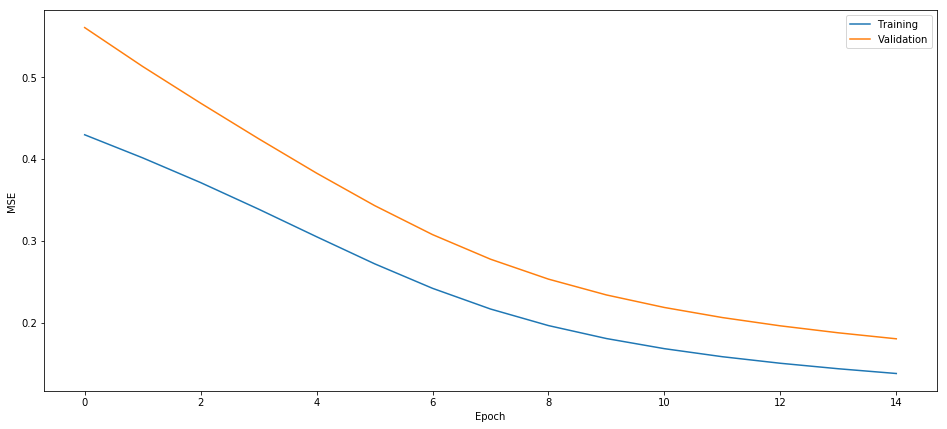

In [18]:
def plot_errors(train_mse, validate_mse):
    epochs = range(len(train_mse))
    plt.plot(epochs, train_mse, label='Training')
    plt.plot(epochs, validate_mse, label='Validation')
    plt.ylabel('MSE')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


figsize(16, 7)
plot_errors(training_mse, validation_mse)

## Checking predicitons on test data

In [19]:
def calculate_reconstruction_errors(input_data, L):
    reconstruction_errors = []
    for i, data in enumerate(input_data):
        input = data.as_in_context(ctx).reshape((-1, feature_count, 1))
        predicted_value = model(input)
        reconstruction_error = L(predicted_value, input).asnumpy().flatten()
        reconstruction_errors = np.append(
            reconstruction_errors, reconstruction_error)

    return reconstruction_errors

In [20]:
all_training_data = mx.gluon.data.DataLoader(
    training_data.astype(np.float32), batch_size, shuffle=False)

training_reconstruction_errors = calculate_reconstruction_errors(
    all_training_data, L)
reconstruction_error_threshold = np.mean(training_reconstruction_errors) + 3 * \
    np.std(training_reconstruction_errors)

In [21]:
test_data = data_scaler.fit_transform(
    test_data_frame[features].values.astype(np.float32)
)

test_data_batches = mx.gluon.data.DataLoader(
    test_data, batch_size, shuffle=False)

test_reconstruction_errors = calculate_reconstruction_errors(
    test_data_batches, L)

predicted_test_anomalies = list(
    map(lambda v: 1 if v > reconstruction_error_threshold else 0,
        test_reconstruction_errors)
)

test_data_frame['anomaly_predicted'] = predicted_test_anomalies

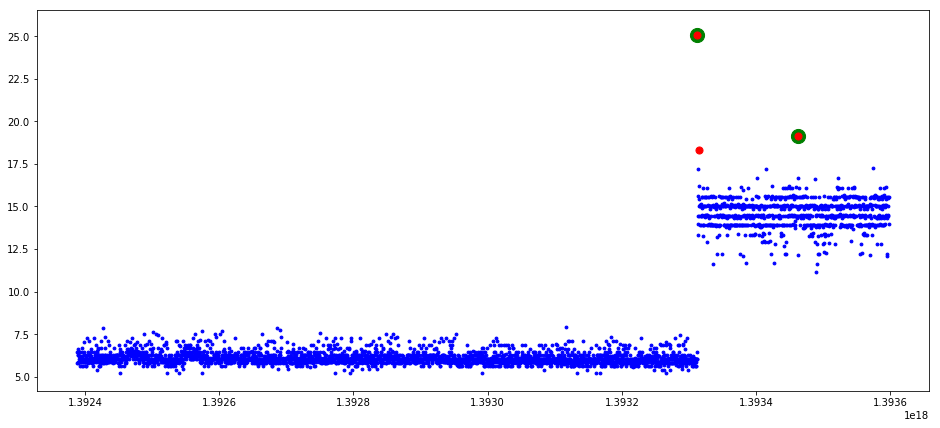

In [22]:
figsize(16, 7)

ax = prepare_plot(test_data_frame)

predicted_anomalies = test_data_frame.loc[test_data_frame['anomaly_predicted'] == 1, [
    'time_epoch', 'value']]
ax.scatter(predicted_anomalies['time_epoch'],
           predicted_anomalies['value'], s=50, color='red')

plt.show()

## F1 score calculation

In [23]:
test_labels = test_data_frame['anomaly_label'].astype(np.float32)

score = f1_score(test_labels, predicted_test_anomalies)
print('F1 score: ' + str(score))

F1 score: 0.8
